<a href="https://colab.research.google.com/github/terrysu64/Machine-Learning-and-Data-Science-Projects/blob/main/feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning - feature extraction

### inspect data

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-07-31 15:24:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.128, 108.177.12.128, 74.125.26.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   237MB/s    in 0.7s    

2022-07-31 15:24:21 (237 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
import os 

for dirpath,dirname,filenames in os.walk("10_food_classes_10_percent"):
  print(dirpath,len(dirname),len(filenames))

10_food_classes_10_percent 2 0
10_food_classes_10_percent/test 10 0
10_food_classes_10_percent/test/grilled_salmon 0 250
10_food_classes_10_percent/test/hamburger 0 250
10_food_classes_10_percent/test/ramen 0 250
10_food_classes_10_percent/test/ice_cream 0 250
10_food_classes_10_percent/test/chicken_wings 0 250
10_food_classes_10_percent/test/pizza 0 250
10_food_classes_10_percent/test/fried_rice 0 250
10_food_classes_10_percent/test/sushi 0 250
10_food_classes_10_percent/test/chicken_curry 0 250
10_food_classes_10_percent/test/steak 0 250
10_food_classes_10_percent/train 10 0
10_food_classes_10_percent/train/grilled_salmon 0 75
10_food_classes_10_percent/train/hamburger 0 75
10_food_classes_10_percent/train/ramen 0 75
10_food_classes_10_percent/train/ice_cream 0 75
10_food_classes_10_percent/train/chicken_wings 0 75
10_food_classes_10_percent/train/pizza 0 75
10_food_classes_10_percent/train/fried_rice 0 75
10_food_classes_10_percent/train/sushi 0 75
10_food_classes_10_percent/train/c

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

#preprocess data
train_datagen = IDG(rescale=1./224,
                    rotation_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True)

valid_datagen = IDG(rescale=1./224)

#paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

#import data and turn to batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode="categorical",
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode="categorical",
                                               seed=42)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### setting up callbacks

e.g:
* tracking experiments via TensorBoard
* Model checkpoint 
* Stopping model before overfitting

In [ ]:
#tensorboard
import datetime
import tensorflow as tf

def tensorboard_callback(dir_name, exp_name):
  log_dir = f"{dir_name}/{exp_name}/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
  callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"saving tensorboard to: {log_dir}")
  return callback

### using tensorflow hub

In [ ]:
import tensorflow_hub as hub

def create_model(url,num_classes=10):
  
  """
  uses tfhub url to create uncompiled sequential model
  url -> feature extraction url
  """

  extractor_layer = hub.KerasLayer(url,
                                   trainable=False,
                                   name="feature_extraction_layer",
                                   input_shape=(224,224,3))
    
  model = tf.keras.Sequential([
      extractor_layer,
      tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

effnet = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
resnet = "https://tfhub.dev/tensorflow/resnet_50/classification/1"

### ResNet model

In [ ]:
resnet_model = create_model(resnet)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1001)             25612201  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 25,622,221
Trainable params: 10,020
Non-trainable params: 25,612,201
_________________________________________________________________


In [ ]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

resnet_tfboard = tensorboard_callback("tensorflow_hub","resnet50V2")
resnet_history = resnet_model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=valid_data,
                    validation_steps=len(valid_data),
                    callbacks=[resnet_tfboard]
                    )

saving tensorboard to: tensorflow_hub/resnet50V2/20220731-153011
Epoch 1/5
24/24 [==============================] - 26s 1s/step - loss: 2.2808 - accuracy: 0.3147 - val_loss: 2.2664 - val_accuracy: 0.4304
Epoch 2/5
24/24 [==============================] - 23s 987ms/step - loss: 2.2663 - accuracy: 0.4573 - val_loss: 2.2501 - val_accuracy: 0.5384
Epoch 3/5
24/24 [==============================] - 23s 956ms/step - loss: 2.2515 - accuracy: 0.5093 - val_loss: 2.2342 - val_accuracy: 0.5680
Epoch 4/5
24/24 [==============================] - 23s 966ms/step - loss: 2.2389 - accuracy: 0.5227 - val_loss: 2.2180 - val_accuracy: 0.5892
Epoch 5/5
24/24 [==============================] - 23s 966ms/step - loss: 2.2246 - accuracy: 0.5467 - val_loss: 2.2027 - val_accuracy: 0.5988


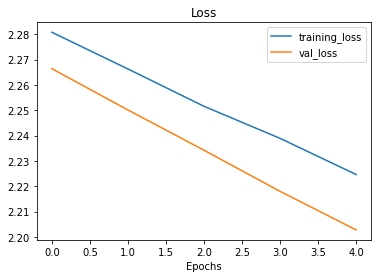

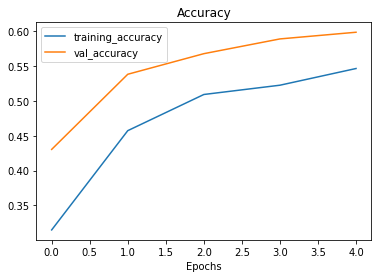

In [ ]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(resnet_history)

### EfficientNetB0 model

In [ ]:
effnet_model = create_model(effnet)

In [17]:
effnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                     metrics=["accuracy"])

effnet_tfboard = tensorboard_callback("tensorflow_hub","efficientnetB0")
effnet_history = resnet_model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=valid_data,
                    validation_steps=len(valid_data),
                    callbacks=[resnet_tfboard]
                    )

saving tensorboard to: tensorflow_hub/efficientnetB0/20220731-155317
Epoch 1/5
24/24 [==============================] - 27s 1s/step - loss: 2.1457 - accuracy: 0.6027 - val_loss: 2.1115 - val_accuracy: 0.6288
Epoch 2/5
24/24 [==============================] - 23s 976ms/step - loss: 2.1296 - accuracy: 0.6160 - val_loss: 2.0968 - val_accuracy: 0.6244
Epoch 3/5
24/24 [==============================] - 31s 1s/step - loss: 2.1189 - accuracy: 0.6160 - val_loss: 2.0820 - val_accuracy: 0.6324
Epoch 4/5
24/24 [==============================] - 23s 956ms/step - loss: 2.1047 - accuracy: 0.6307 - val_loss: 2.0676 - val_accuracy: 0.6304
Epoch 5/5
24/24 [==============================] - 23s 960ms/step - loss: 2.0939 - accuracy: 0.6320 - val_loss: 2.0532 - val_accuracy: 0.6300


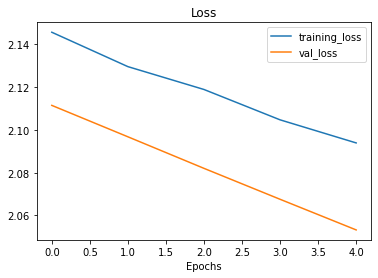

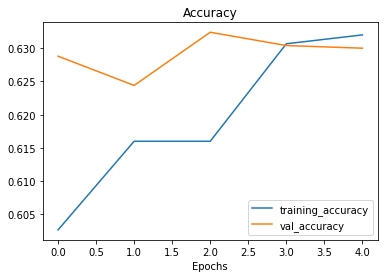

In [18]:
plot_loss_curves(effnet_history)

**different types of transfer learning** 🧐:


*  As is -> use existing model with no changes
*  Feature extraction
*  Fine tuning -> fine tune layers of existing model





### comparing results via TensorBoard

In [21]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "Efficientnet vs Resnet" \
--description "comparing two models for feature extraction" \
--one_shot



***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=WDuiK78DmQ4PDMV9nqMbQXfHnm24BN&prompt=consent&access_type=off

 https://tensorboard.dev/experiment/66sGNQIjRpOXUDRL3XBCvA/

In [24]:
!tensorboard dev list

https://tensorboard.dev/experiment/66sGNQIjRpOXUDRL3XBCvA/
	Name                 Efficientnet vs Resnet
	Description          comparing two models for feature extraction
	Id                   66sGNQIjRpOXUDRL3XBCvA
	Created              2022-07-31 16:37:14 (3 minutes ago)
	Updated              2022-07-31 16:37:16 (3 minutes ago)
	Runs                 2
	Tags                 5
	Scalars              90
	Tensor bytes         0
	Binary object bytes  2601153
Total: 1 experiment(s)
